In [ ]:
# https://github.com/Koukyosyumei/AIJack
!apt install -y libboost-all-dev
!pip install -U pip
!pip install "pybind11[global]"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-all-dev is already the newest version (1.71.0.0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.4/401.4 kB 20.5 MB/s eta 0:00:00


In [ ]:
!pip install aijack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for aijack: filename=aijack-0.0.1a2-cp310-cp310-linux_x86_64.whl size=531178 sha256=144cb153be03a8e84c4942b0426e77a530fc664b4cb8409d84da03629820ba73
  Stored in directory: /root/.cache/pip/wheels/a3/91/c5/ccfc7d5a68b78e39783a9a7e4c3906f5d362368aa6a85ba773
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp310-cp310-linux_x86_64.whl size=3365660 sha256=a1e8eafb1d146a2d18ac64ad83cc96b0bf3e3a2e7ca48374c27cf73072b4d62e
  Stored in directory: /root/.cache

In [ ]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from numpy import e
from matplotlib import pyplot as plt
import torch.optim as optim
from tqdm.notebook import tqdm

from aijack.collaborative.fedavg import FedAVGAPI, FedAVGClient, FedAVGServer
from aijack.attack.inversion import GradientInversionAttackServerManager
from torch.utils.data import DataLoader, TensorDataset
from aijack.utils import NumpyDataset

import warnings

warnings.filterwarnings("ignore")

In [ ]:
#making convolution neural layer
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(nn.Linear(hideen, num_classes))

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
#Data preparation and conversion/transform of PIL into numpy arrays
def prepare_dataloader(path="MNIST/.", batch_size=64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.MNIST(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    dataset = NumpyDataset(
        at_t_dataset_train.train_data.numpy(),
        at_t_dataset_train.train_labels.numpy(),
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )
    return dataloader

In [ ]:
torch.manual_seed(7777) #torch.manual_seed function. Setting a random seed ensures that the random processes within PyTorch

shape_img = (28, 28)
num_classes = 10
channel = 1 #grayscale imgs
hidden = 588 #This line sets the number of hidden units (or neurons) in the fully connected layer of the LeNet architecture. The value of 588 is applicabel to this implementation.

num_seeds = 5

Reconstruct single data

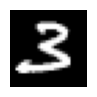

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu" #device usage if gpu available else use cpu
dataloader = prepare_dataloader()
for data in dataloader:
    xs, ys = data[0], data[1] #The data loader will provide batches of training samples for iteration.
    break

x = xs[:1]
y = ys[:1] #select first 4 samples from xs and ys, representing a subset of the input images and their labels.

fig = plt.figure(figsize=(1, 1)) #visualizes the first image in the selected subset (x).
plt.axis("off")
plt.imshow(x.detach().numpy()[0][0], cmap="gray")
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss() 
#a loss function is used to quantify the difference between the predicted output and the ground truth labels. 
#The CrossEntropyLoss function combines two components: softmax activation and the negative log-likelihood loss.
#By using the CrossEntropyLoss function as the criterion, you can train your neural network using techniques such as gradient descent 
#to minimize the loss and improve the network's ability to correctly classify the input data.


Deep leakage from gradient (DLG)

You can convert the normal server to the malicious attacker with GradientInversionAttackServerManager.

https://dlg.mit.edu/assets/NeurIPS19_deep_leakage_from_gradients.pdf

distance metric = L2 norm

optimize labels

communication 0, epoch 0: client-1 2.1279006004333496
iter=71: loss did not improve in the last 50 rounds.
iter=64: loss did not improve in the last 50 rounds.
iter=69: loss did not improve in the last 50 rounds.
iter=66: loss did not improve in the last 50 rounds.
iter=64: loss did not improve in the last 50 rounds.


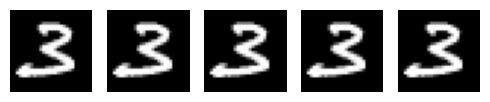

In [ ]:
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=100,
    distancename="l2",
    device=device,
    lr=1.0,
)
DLGFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = DLGFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

Deep Leakage from Gradient


communication 0, epoch 0: client-1 2.2911393642425537
iter=78: loss did not improve in the last 50 rounds.
iter=72: loss did not improve in the last 50 rounds.
iter=90: loss did not improve in the last 50 rounds.
iter=71: loss did not improve in the last 50 rounds.


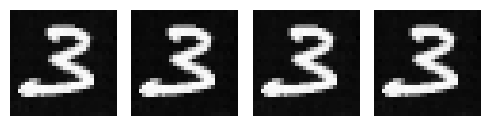

In [ ]:
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=100,
    tv_reg_coef=0.01,
    distancename="cossim",
    device=device,
    lr=1.0,
)
GSFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = GSFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

iDLG Attack
https://arxiv.org/abs/2001.02610

distance metric = L2 norm

analytically estimate a label from the gradients

communication 0, epoch 0: client-1 2.2911393642425537


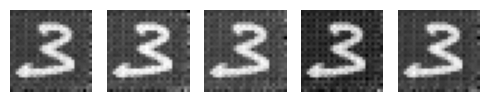

In [ ]:
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=1000,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    device=device,
    lr=1.0,
)
iDLGFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = iDLGFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


Reconstruct Batched Data

Second, we simulate the situation with larger batch size. We try to recover the bellow three images.

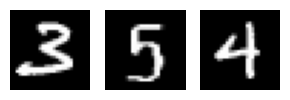

In [ ]:
batch_size = 3
x_batch = xs[:batch_size]
y_batch = ys[:batch_size]

fig = plt.figure(figsize=(3, 2))
for bi in range(batch_size):
    ax = fig.add_subplot(1, batch_size, bi + 1)
    ax.imshow(x_batch[bi].detach().numpy()[0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

GradInversion
https://arxiv.org/abs/2104.07586

distance metric = L2 norm

analytically estimate labels from the gradients

reguralization: total-variance, l2, bn, and group-consistency

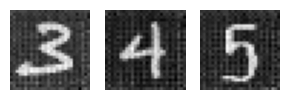

In [ ]:
from aijack.attack.inversion import GradientInversion_Attack

net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x_batch)
loss = criterion(pred, y_batch)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gradinversion = GradientInversion_Attack(
    net,
    (1, 28, 28),
    num_iteration=1000,
    lr=1e2,
    log_interval=0,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
    group_num=3,
    tv_reg_coef=0.00,
    l2_reg_coef=0.0001,
    bn_reg_coef=0.001,
    gc_reg_coef=0.001,
)

result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

fig = plt.figure(figsize=(3, 2))
for bid in range(batch_size):
    ax1 = fig.add_subplot(1, batch_size, bid + 1)
    ax1.imshow((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], cmap="gray")
    ax1.axis("off")
plt.tight_layout()
plt.show()